In [1]:
#!wget "https://s3.eu-central-1.amazonaws.com/avg-kitti/data_road_right.zip"

In [2]:
#!wget "https://s3.eu-central-1.amazonaws.com/avg-kitti/data_road_velodyne.zip"

In [1]:
!wget "https://s3.eu-central-1.amazonaws.com/avg-kitti/data_road.zip"

--2021-01-21 05:54:53--  https://s3.eu-central-1.amazonaws.com/avg-kitti/data_road.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.140.99
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.140.99|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 470992343 (449M) [application/zip]
Saving to: ‘data_road.zip’

data_road.zip       100%[===================>] 449.17M  32.7MB/s    in 14s     

2021-01-21 05:55:07 (31.2 MB/s) - ‘data_road.zip’ saved [470992343/470992343]



In [2]:
!unzip "data_road.zip"

Archive:  data_road.zip
   creating: data_road/
   creating: data_road/training/
   creating: data_road/testing/
   creating: data_road/training/image_2/
  inflating: data_road/training/image_2/umm_000032.png  
  inflating: data_road/training/image_2/umm_000031.png  
  inflating: data_road/training/image_2/umm_000030.png  
  inflating: data_road/training/image_2/umm_000029.png  
  inflating: data_road/training/image_2/umm_000028.png  
  inflating: data_road/training/image_2/umm_000027.png  
  inflating: data_road/training/image_2/umm_000026.png  
  inflating: data_road/training/image_2/umm_000025.png  
  inflating: data_road/training/image_2/umm_000024.png  
  inflating: data_road/training/image_2/umm_000023.png  
  inflating: data_road/training/image_2/umm_000022.png  
  inflating: data_road/training/image_2/umm_000021.png  
  inflating: data_road/training/image_2/umm_000020.png  
  inflating: data_road/training/image_2/umm_000019.png  
  inflating: data_road/training/image_2/umm_0000

In [3]:
import cv2
import numpy as np
import os

In [4]:
train_folder_y = os.path.sep.join(['data_road', 'training', 'gt_image_2'])
train_folder_x = os.path.sep.join(['data_road', 'training', 'image_2'])

In [5]:
x_train = []
y_train = []
resize = True
img_size = 224
for img in os.listdir(train_folder_y):
  y = os.path.join(train_folder_y, img)
  filename = img.split("_")
  filename = filename[0] + "_" + filename[2]
  x = os.path.join(train_folder_x, filename)

  x = cv2.imread(x)

  y = cv2.imread(y)

  if resize:
    x = cv2.resize(x, (img_size, img_size))
    y = cv2.resize(y, (img_size, img_size))
  y = cv2.cvtColor(y, cv2.COLOR_BGR2GRAY)
  y[y == 105] = 1
  y[y != 1] = 0
  y = np.expand_dims(y, axis=2)

  x_train.append(x)
  y_train.append(y)

x_train = np.array(x_train) / 255.0
y_train = np.array(y_train)
print(x_train.shape)
print(y_train.shape)

(384, 224, 224, 3)
(384, 224, 224, 1)


In [8]:
from tensorflow.keras import layers

In [9]:
from tensorflow import keras

In [10]:

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x)
    #outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model((224, 224), num_classes=1)
# model = get_model((224, 224), num_classes=2)
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [11]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
#model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
#model.compile(optimizer="adam", loss=None)
callbacks = [
    keras.callbacks.ModelCheckpoint("road_lane.h5", save_best_only=True)
]
epochs = 100

In [14]:

model.fit(x=x_train, y=y_train, epochs=epochs, callbacks=callbacks)

Epoch 1/150
12/12 [==============================] - 15s 367ms/step - loss: 1.4586
Epoch 2/150
12/12 [==============================] - 4s 368ms/step - loss: 0.2071
Epoch 3/150
12/12 [==============================] - 4s 368ms/step - loss: 0.1654
Epoch 4/150
12/12 [==============================] - 4s 374ms/step - loss: 0.1671
Epoch 5/150
12/12 [==============================] - 4s 373ms/step - loss: 0.1421
Epoch 6/150
12/12 [==============================] - 5s 379ms/step - loss: 0.1297
Epoch 7/150
12/12 [==============================] - 5s 379ms/step - loss: 0.1225
Epoch 8/150
12/12 [==============================] - 5s 381ms/step - loss: 0.1178
Epoch 9/150
12/12 [==============================] - 5s 384ms/step - loss: 0.1229
Epoch 10/150
12/12 [==============================] - 5s 386ms/step - loss: 0.1116
Epoch 11/150
12/12 [==============================] - 5s 389ms/step - loss: 0.1033
Epoch 12/150
12/12 [==============================] - 5s 394ms/step - loss: 0.0986
Epoch 13/150

# Testing


In [57]:
test_folder = os.path.sep.join(['data_road', 'testing', 'image_2'])

In [58]:
import random
import matplotlib.pyplot as plt

In [69]:
def segment():
  img = random.choice(os.listdir(test_folder))
  img_name = img
  img = cv2.imread(os.path.join(test_folder, img))
  img2 = img.copy()
  img1 = img.copy()
  h, w, c = img.shape
  img = cv2.resize(img, (224, 224)) / 255.0
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = model.predict(img.reshape(1, 224, 224, 3)).reshape(224, 224)
  img[img > 0.5] = 255
  img[img < 0.5] = 0

  img = cv2.resize(img, (w, h))
  img1[:, :, 0] = img
  img1[:, :, 1] = img
  img1[:, :, 2] = img

  mask = cv2.bitwise_or(img2, img1)

  mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
  img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

  fig = plt.figure(figsize=(25, 25))
  ax1 = fig.add_subplot(2,2,1)
  ax1.imshow(mask)
  ax2 = fig.add_subplot(2,2,2)
  ax2.imshow(img2)

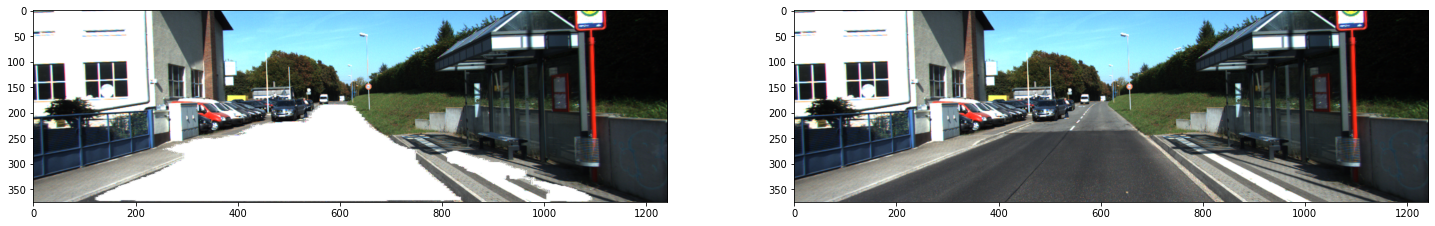

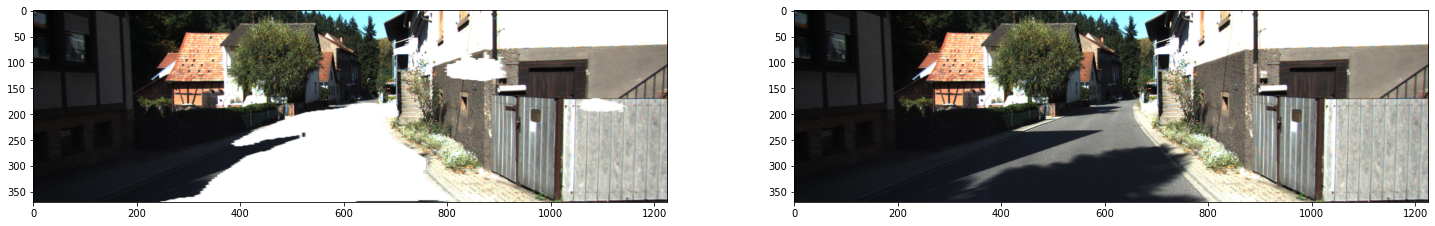

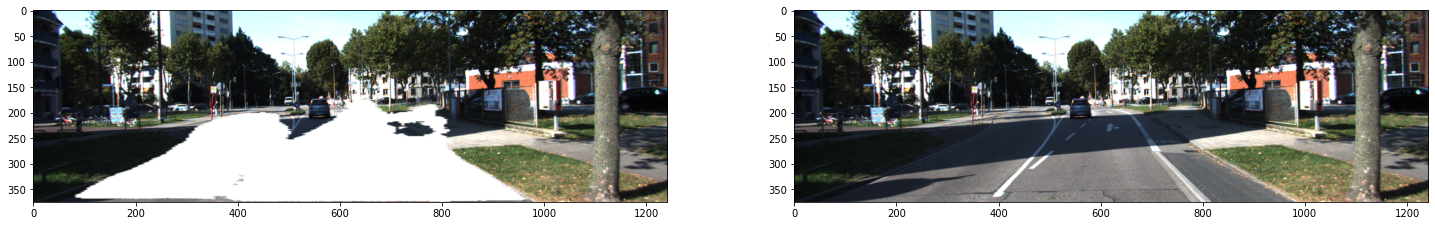

In [74]:
segment()
segment()
segment()